In [91]:
import pandas as pd
import random
from dataset import *

In [92]:
!pip install -q -U segmentation-models-pytorch albumentations
import segmentation_models_pytorch as smp

In [93]:
# import splitfolders
#
# splitfolders.ratio('dataset/all', output="dataset/split", seed=1337, ratio=(0.7, 0.2, 0.1))

In [94]:
DATA_DIR = os.path.join('dataset', 'split')

x_train_dir = os.path.join(DATA_DIR, 'train', 'images')
y_train_dir = os.path.join(DATA_DIR, 'train', 'masks')

x_valid_dir = os.path.join(DATA_DIR, 'val', 'images')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'masks')

x_test_dir = os.path.join(DATA_DIR, 'test', 'images')
y_test_dir = os.path.join(DATA_DIR, 'test', 'masks')

In [95]:
# Get class names
class_names = ['background', 'human']
# Get class RGB values
class_rgb_values = [[0, 0, 0], [255, 255, 255]]

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_rgb_values)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  [[0, 0, 0], [255, 255, 255]]
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [96]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 50

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH = os.path.join('model', 'best_model.pth')

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

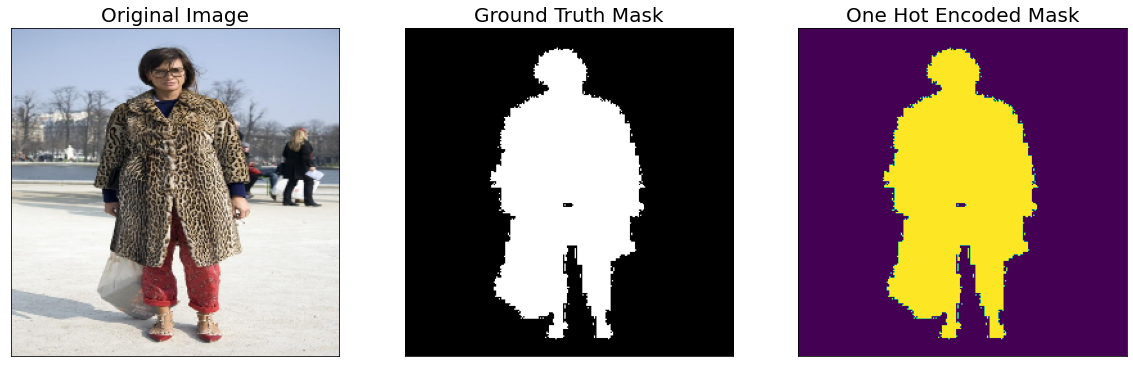

In [97]:
dataset = HumanDataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)

random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

visualize(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

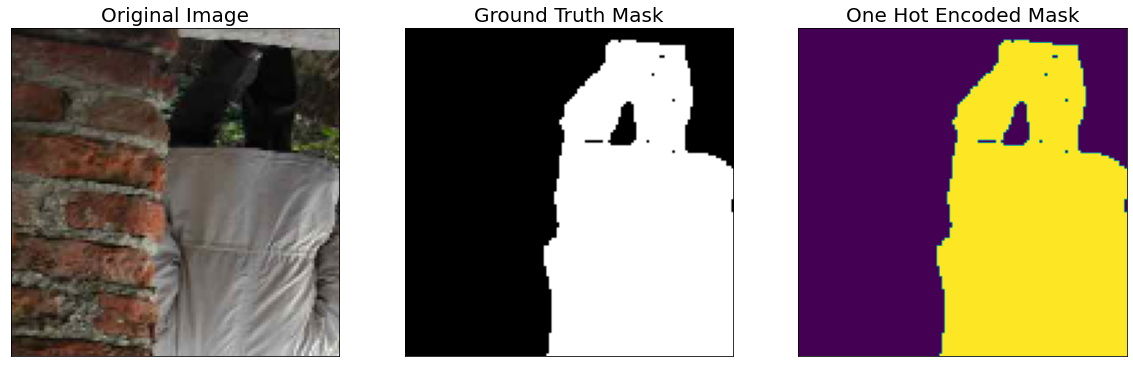

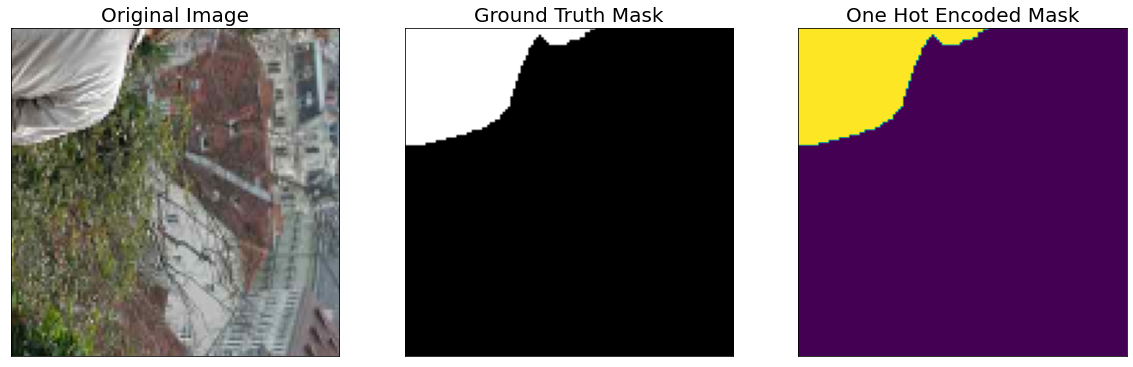

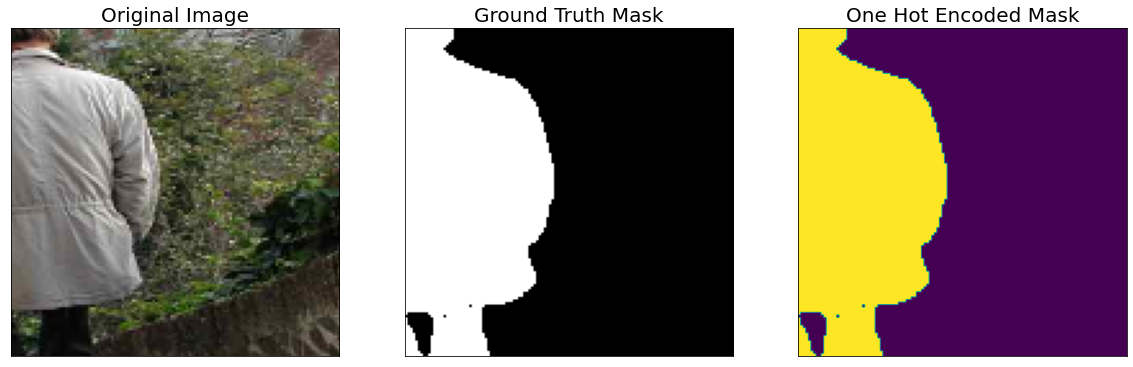

In [98]:
augmented_dataset = HumanDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset) - 1)

# Different augmentations on a random image/mask pair (128*128 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image=image,
        ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
        one_hot_encoded_mask=reverse_one_hot(mask)
    )

In [99]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/andrew/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [100]:
# Get train and val dataset instances
train_dataset = HumanDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

valid_dataset = HumanDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [101]:
# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# load best saved model checkpoint from previous commit (if present)
if os.path.exists(MODEL_PATH):
    model = torch.load(MODEL_PATH, map_location=DEVICE)

In [102]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [103]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, MODEL_PATH)
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 258/258 [00:02<00:00, 88.38it/s, dice_loss - 0.222, iou_score - 0.87]    
Model saved!

Epoch: 1
valid: 100%|██████████| 258/258 [00:02<00:00, 88.16it/s, dice_loss - 0.1977, iou_score - 0.9059]
Model saved!

Epoch: 2
valid: 100%|██████████| 258/258 [00:03<00:00, 78.60it/s, dice_loss - 0.1697, iou_score - 0.9047]

Epoch: 3
valid: 100%|██████████| 258/258 [00:03<00:00, 82.59it/s, dice_loss - 0.1456, iou_score - 0.9142]
Model saved!

Epoch: 4
valid: 100%|██████████| 258/258 [00:03<00:00, 83.50it/s, dice_loss - 0.1171, iou_score - 0.9314]
Model saved!

Epoch: 5
valid: 100%|██████████| 258/258 [00:03<00:00, 83.67it/s, dice_loss - 0.09776, iou_score - 0.9328]
Model saved!

Epoch: 6
valid: 100%|██████████| 258/258 [00:03<00:00, 84.71it/s, dice_loss - 0.09652, iou_score - 0.9282]

Epoch: 7
valid: 100%|██████████| 258/258 [00:02<00:00, 86.52it/s, dice_loss - 0.08443, iou_score - 0.9267]

Epoch: 8
valid: 100%|██████████| 258/258 [00:02<00:00, 86.14it/s, dice_los

In [104]:
# load best saved model checkpoint from the current run
best_model = torch.load(MODEL_PATH, map_location=DEVICE)
print('Loaded DeepLabV3+ model')

Loaded DeepLabV3+ model


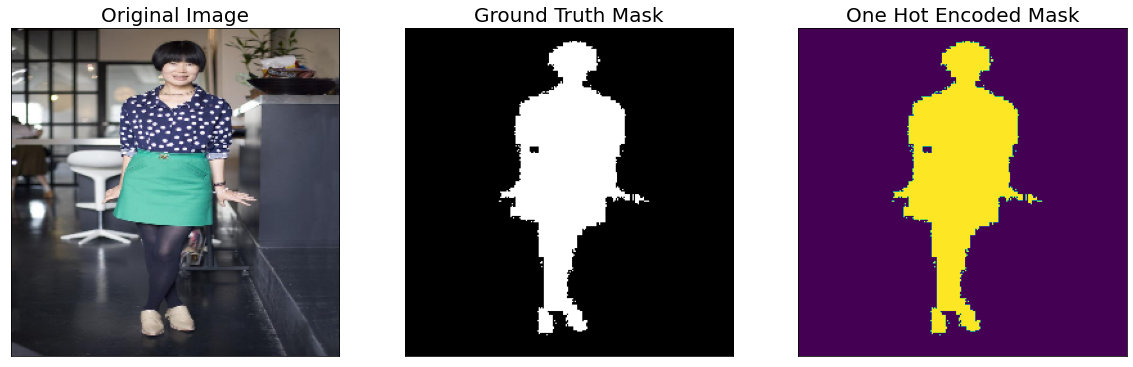

In [105]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = HumanDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = HumanDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis) - 1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

In [106]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

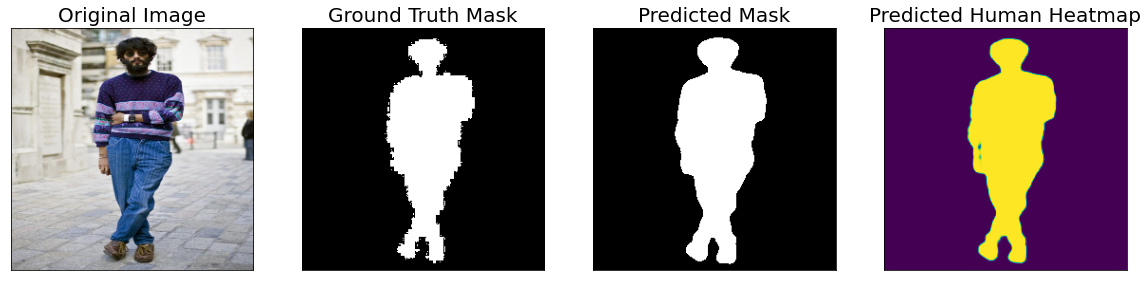

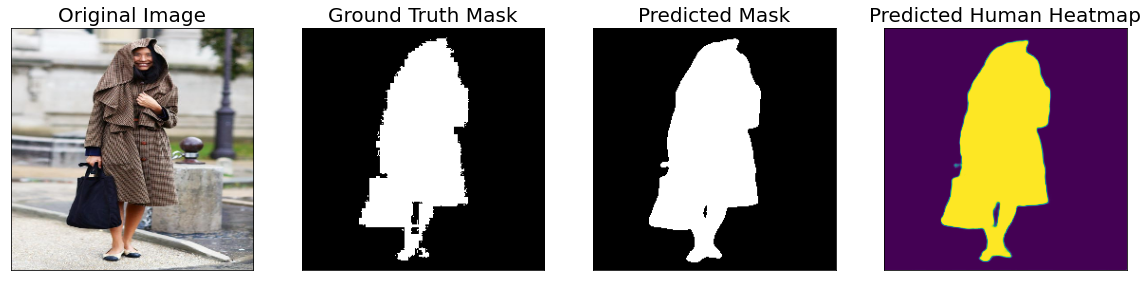

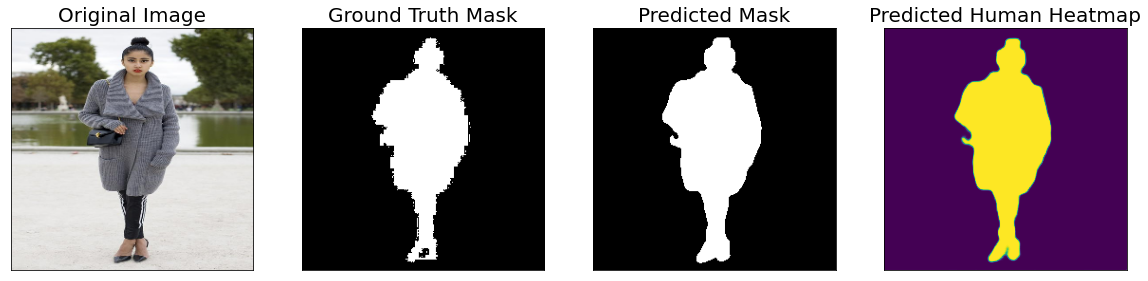

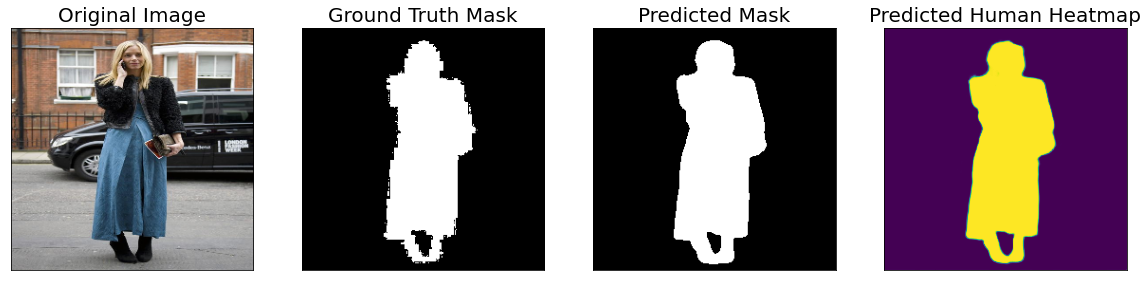

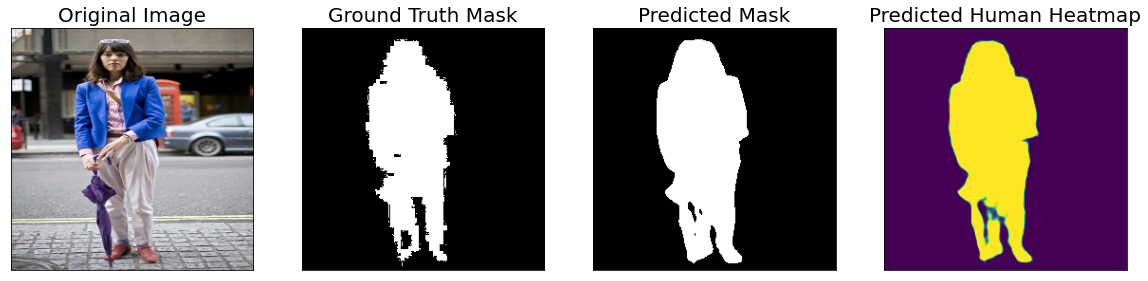

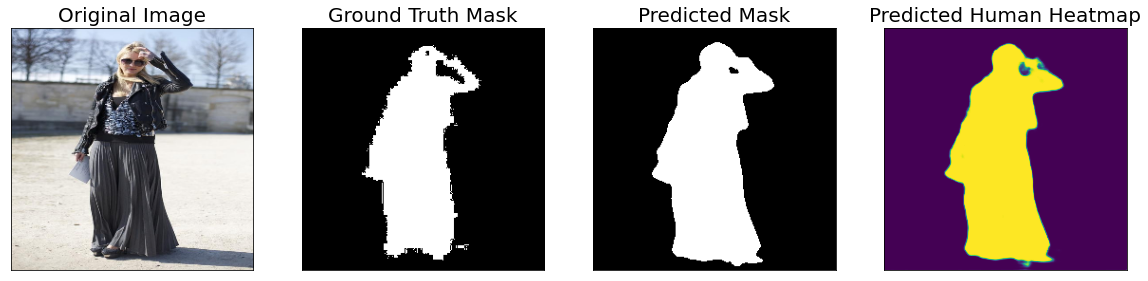

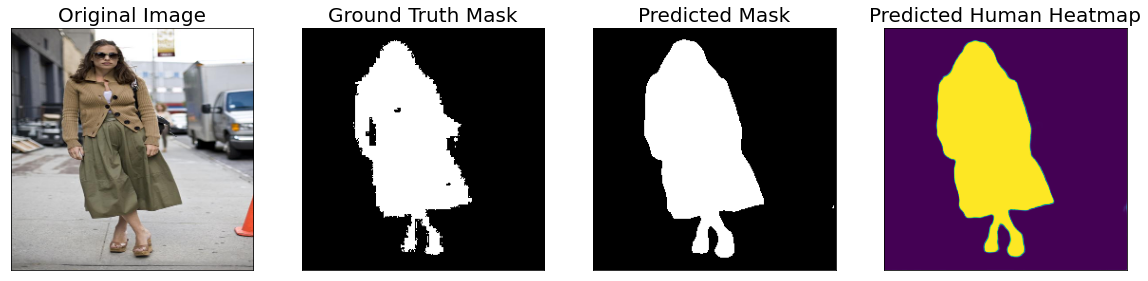

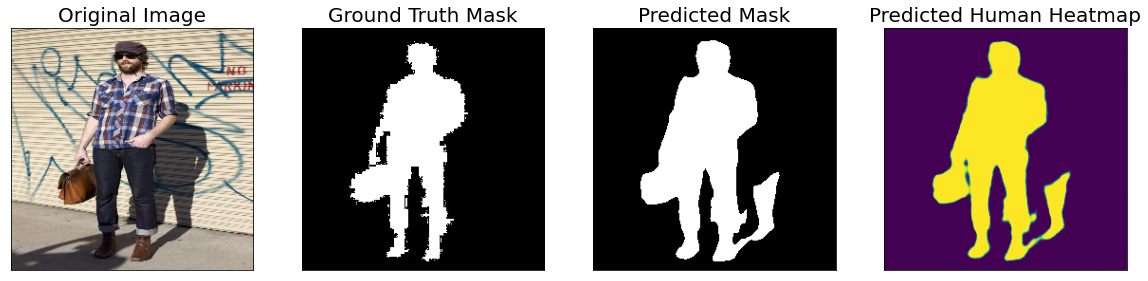

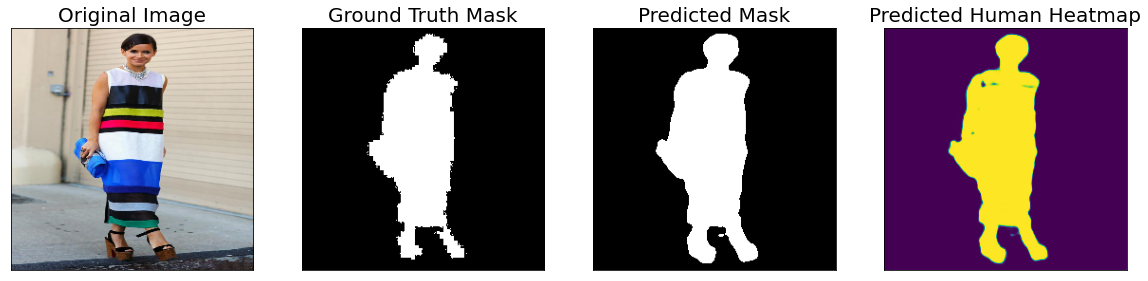

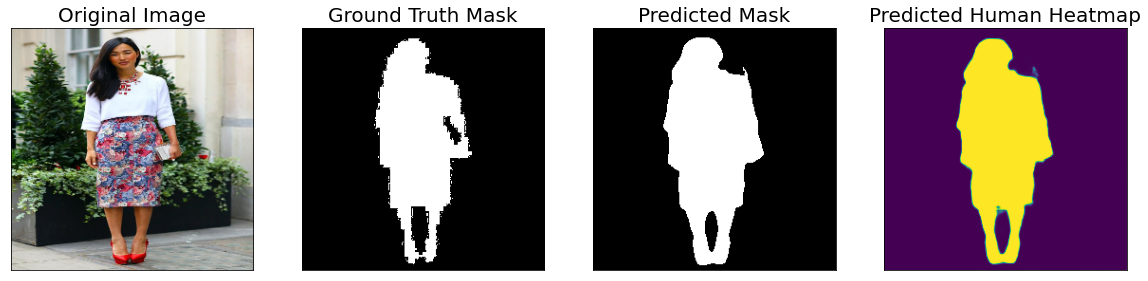

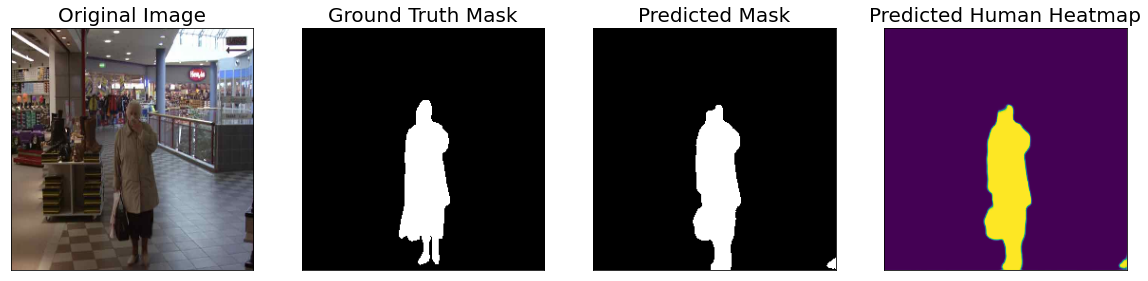

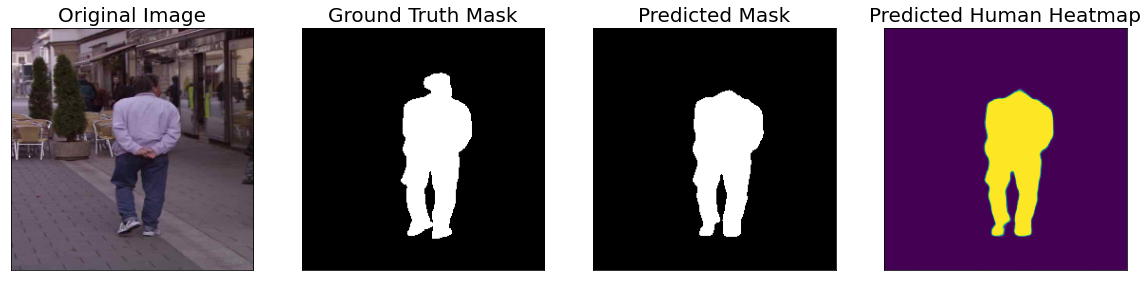

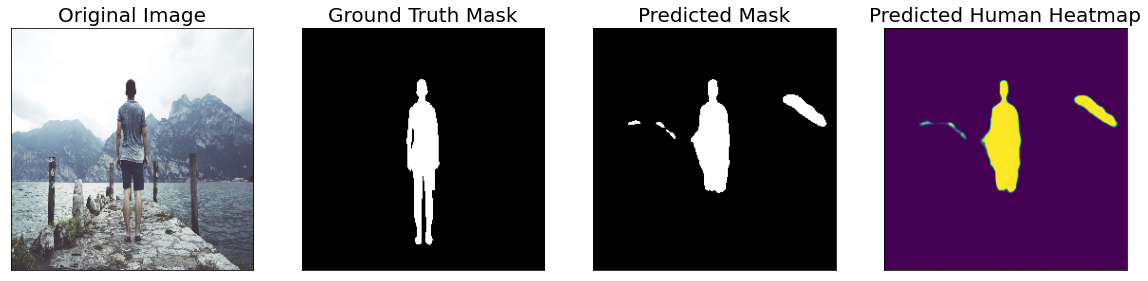

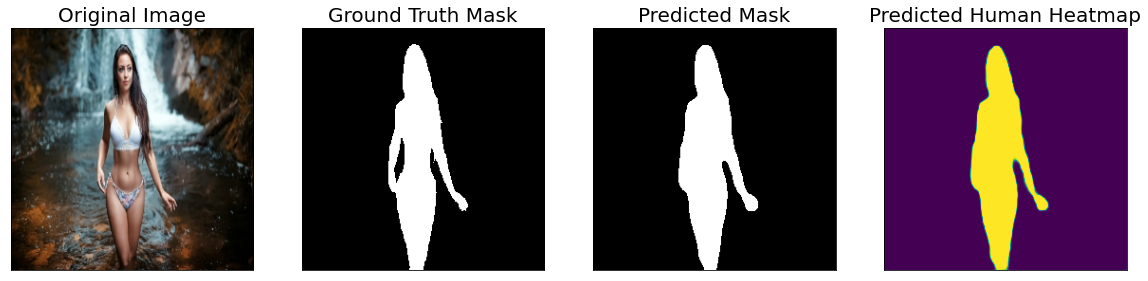

In [107]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask, (1, 2, 0))

    # Get prediction channel corresponding to human
    pred_human_heatmap = pred_mask[:, :, class_names.index('human')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values)

    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values)

    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"),
                np.hstack([image_vis, gt_mask, pred_mask])[:, :, ::-1])

    # visualize every 10 prediction
    if idx % 10 == 0:
        visualize(
            original_image=image_vis,
            ground_truth_mask=gt_mask,
            predicted_mask=pred_mask,
            predicted_human_heatmap=pred_human_heatmap
        )

In [108]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 131/131 [00:03<00:00, 43.43it/s, dice_loss - 0.02961, iou_score - 0.9474]
Evaluation on Test Data: 
Mean IoU Score: 0.9474
Mean Dice Loss: 0.0296


In [109]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
dice_loss,0.355294,0.221471,0.182462,0.156031,0.137612,0.120126,0.110942,0.100073,0.092037,0.08372,...,0.044811,0.044735,0.048105,0.049009,0.046010,0.048648,0.043266,0.043055,0.041834,0.041041
iou_score,0.606735,0.815893,0.847327,0.863790,0.868099,0.880673,0.880166,0.886140,0.888982,0.89687,...,0.919894,0.919909,0.913441,0.911228,0.916902,0.911808,0.921441,0.921687,0.923832,0.925105


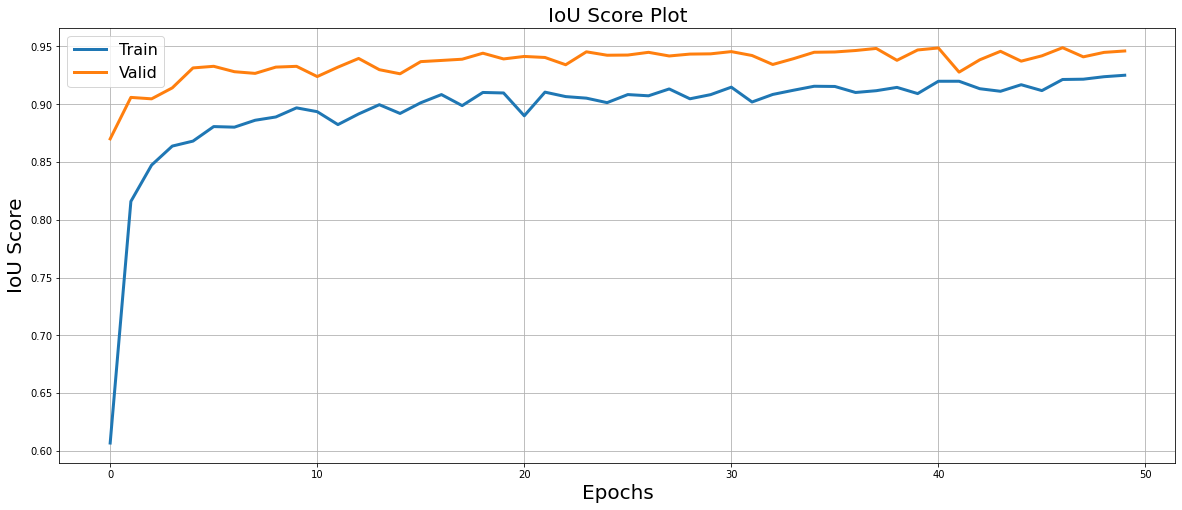

In [110]:
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

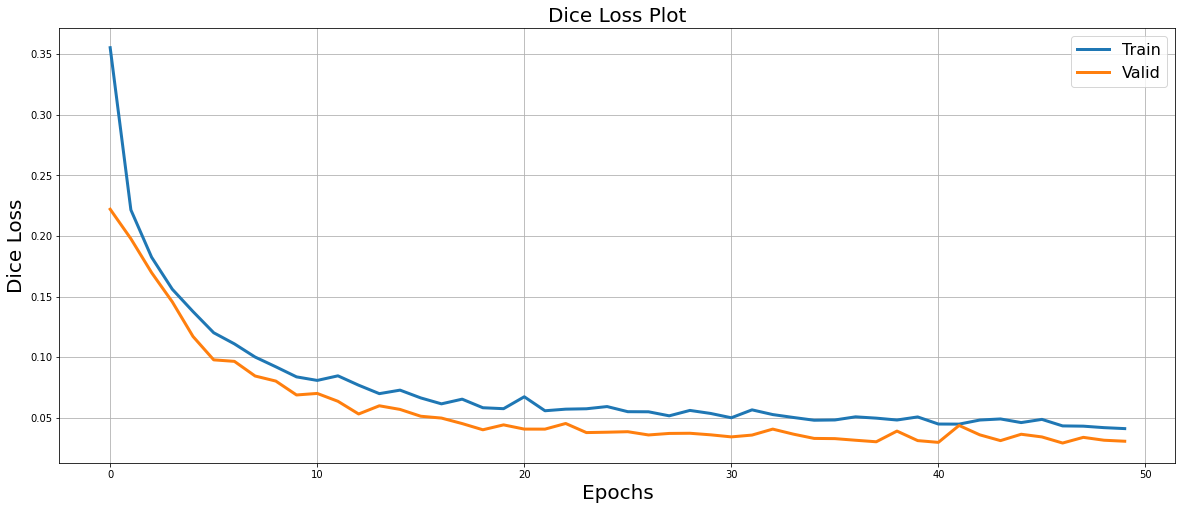

In [111]:
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()